# 交通信号灯检测模型 Demo
这个notebook将引导您逐步完成使用预训练的交通信号灯模型检测图像中信号灯的过程。 在开始之前，请务必遵循安装说明:https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## 导入信号灯检测
在此导入信号灯检测模型

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

/home/adam/data/models/research/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-pack

# 模型准备

## 预训练权重参数

使用`export_inference_graph.py` 导出的模型可以在这里使用 `PATH_TO_FROZEN_GRAPH` 指定.  

In [4]:
# 冻结的检测模型（protocbuf格式）的路径，这是用于信号灯检测的实际模型。
PATH_TO_FROZEN_GRAPH = '/home/adam/data/tl_detector/new-export/frozen_inference_graph.pb'

# label map
PATH_TO_LABELS = '/home/adam/data/tl_detector/lisa_label_map.pbtxt'

# 交通信号灯检测为3
NUM_CLASSES = 3

## 加载预训练模型

In [5]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## 加载 label map
Label maps将索引映射到类别名称，因此当我们的卷积网络预测“1”时，我们知道这对应于“绿灯”。 

In [6]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index)

{1: {'name': 'green', 'id': 1}, 2: {'name': 'red', 'id': 2}, 3: {'name': 'yellow', 'id': 3}}


## 辅助代码

In [7]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# 检测

In [15]:
import os
PATH_TO_TEST_IMAGES_DIR = '/home/adam/data/tl_detector/test-example/'
image_list = os.listdir(PATH_TO_TEST_IMAGES_DIR)
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, i) for i in image_list ]
print(TEST_IMAGE_PATHS)
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

['/home/adam/data/tl_detector/test-example/26102.png', '/home/adam/data/tl_detector/test-example/27052.png', '/home/adam/data/tl_detector/test-example/27630.png', '/home/adam/data/tl_detector/test-example/24952.png', '/home/adam/data/tl_detector/test-example/26576.png', '/home/adam/data/tl_detector/test-example/28068.png', '/home/adam/data/tl_detector/test-example/27176.png']


In [16]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

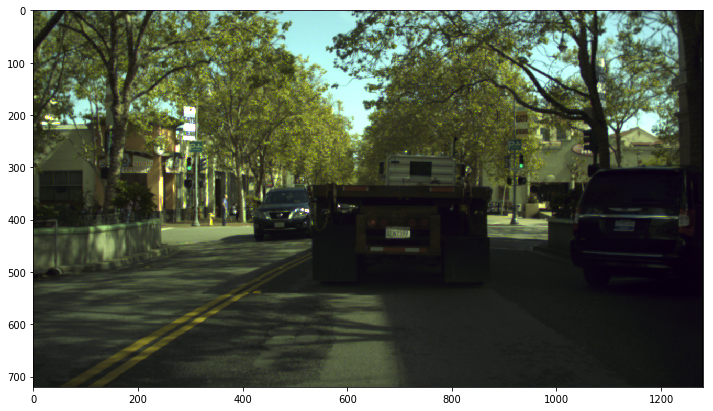

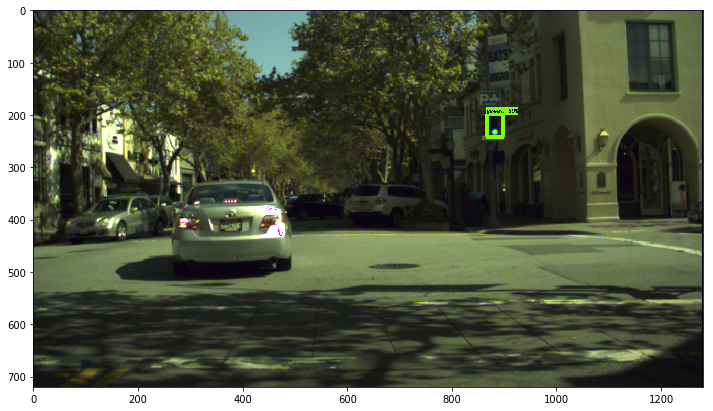

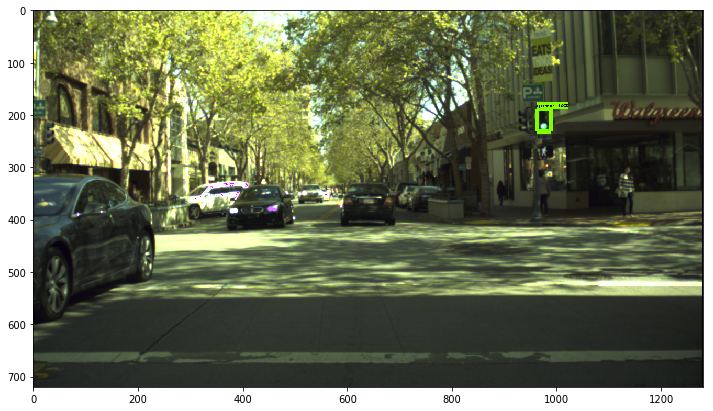

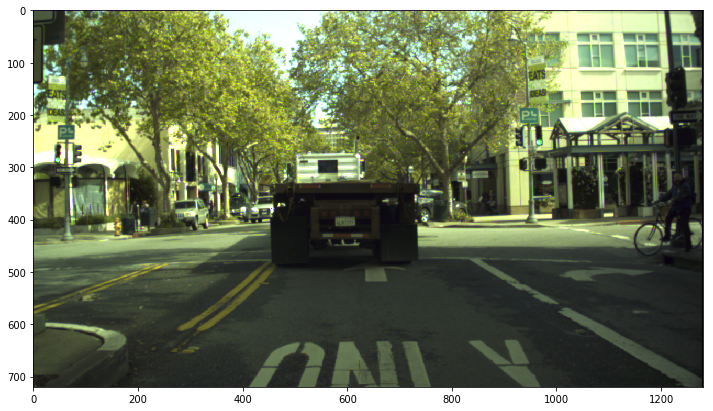

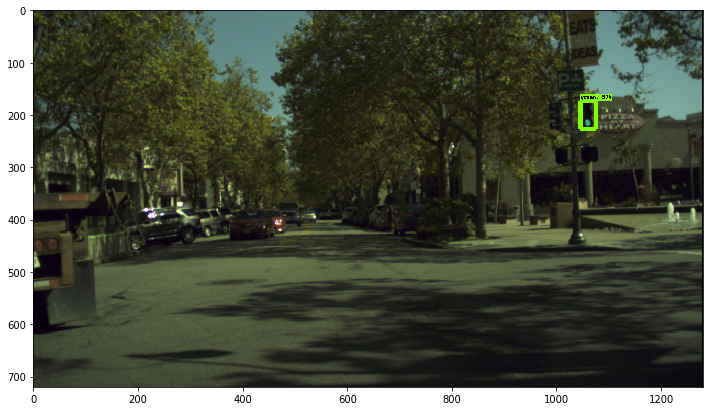

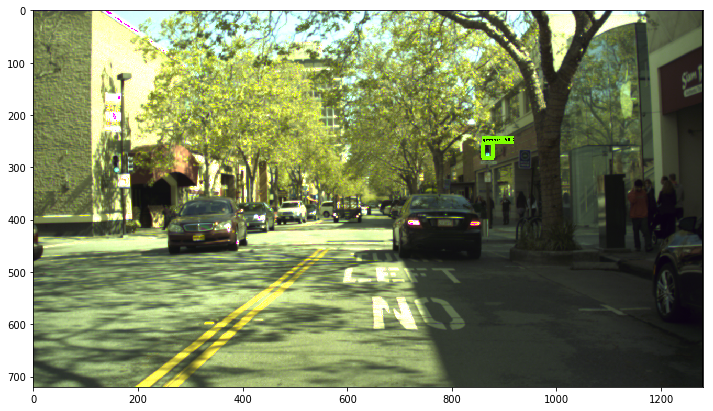

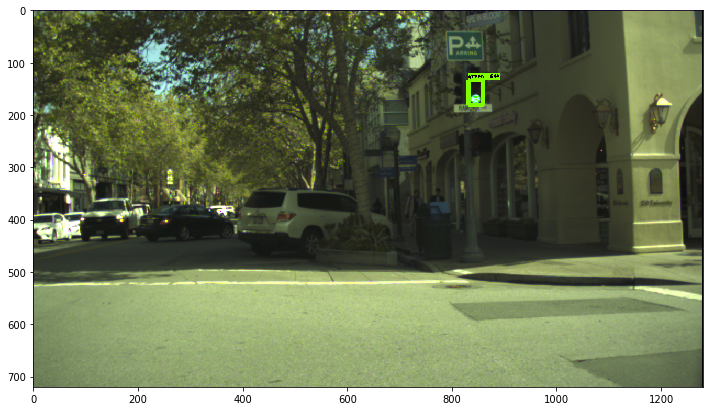

In [17]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)